Goroutines and Channels
=======================

Goroutines and Channels are about modelling concurrency in your programs.
They map rather directly to Concurrent Sequetial Processes, which are processes that send immutable messages to each other, rather than by sharing memory between processes.
If you think about it, this is how processes must interact if they are on different machines.
The fact that buffered channels block, rather than throw errors when they are full is useful for writing code that safely stays within its resources limits; rather than running out of memory or file handles.

Let us start off investigating the Universal Scalabiliyt Law, that explains where potential concurrency gets lost; in queues and in coordination. I promise that this matters, especially because Go has native queues in the form of channels.

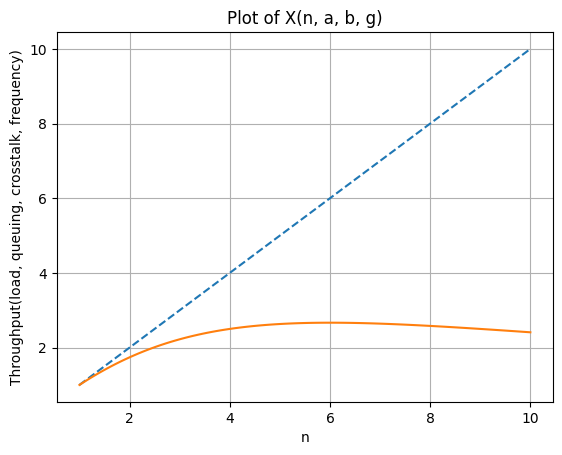

In [14]:
# The Universal Scalability Law
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def X(n, a, b, g):
    return (g * n) / (1 + a * (n - 1) + b * n * (n - 1))

# Set parameters
a = 0.1
b = 0.025
g = 1.0
n_values = np.linspace(1, 10, 100)  # Values of n from 1 to 10

# Calculate X for each n
X_values = X(n_values, a, b, g)

# Plot
plt.plot(n_values, n_values, label="y = x", linestyle="--")
plt.plot(n_values, X_values)
plt.xlabel("n")
plt.ylabel("Throughput(load, queuing, crosstalk, frequency)")
plt.title("Plot of X(n, a, b, g)")
plt.grid(True)
plt.show()



The relationship between load (which is the variable _n_), versus throughput (the variable _X(n)_ in the graph) is important to understand in a deep way. The linear curve shown as a dotted line is the ideal case of total throughput scaling up linearly. The curve that peaks and levels off later is a more realistic case, where taking on more load actually causes lower total throughput. This is an extreme waste of resources. By the time we get to 10 processes, there is almost no work actually getting done.

This curve can be empirically measured, by capturing simultaneous pairs of _(throughput,load)_ and making parameters fit the resulting curve. Once the curve is fit, you can measure where your linear scalability potential went. There were either queues that create an upper throughput limit that you cannot get past or it created coordination that creates a point at which throughput drops off when load increases. In other words, adding more workers causes total work getting done to slow down.

In practical terms, you can measure where throwing money at a problem will break down. There will be situations where scaling up will not be handled by anything other than reducing crosstalk or queueing. From this graph:

- At 4 concurrent tasks, we have almost as much throughput as we can ever get.
- At 6 concurrent tasks, we will never get more throughput. We are "at capacity".
- At 8 concurrent tasks, more workers creates less throughput. We are "over capacity". There is almost no work being done, in spite of 8 workers.

Examples of systems that are known for a bit of queueing:
- nodejs
- python

Systems with a lot of cross-talk, because they replicate data
- Zookeeper
- Bitcoin

Some Java systems get beaten by nodejs implementations, just because of some internal details that end up doing more crosstalk. Crosstalk is an insidious performance issue. It can be thought of a constantly occurring "all-hands-meeting".

Fully Utilizing Hardware
========================

The main issue is that you have a machine that may have 8 cores, and each core has 2 hardware threds. For a CPU-bound task, it will not be possible to get a concurrency of more than 16. The number named "Concurrency" is literally the sum of times that each task took, divided by real-time during that period.

$$
concurrency = \frac{\sum_i (tstop_i - tstart_i)}{tstop - tstart}
$$

You would actually measure this in Go code like this. Each task time is summed together, and divided by real-time.

```go
	// not just a return value, but statistics can come back with return value and errors
    type Receipt struct {
        Result   int
		Duration int64
	}

    // Start timing the task
	then := time.Now().UnixMilli()
    // this task list cannot have more than 64
	taskList := make(chan chan Receipt, 64)

    // Run a bunch of things in parallel, filling the task list
	go func() {
		for {
            // wait on done
			done := make(chan Receipt)
            // this will block when 64 tasks are in progress
			taskList <- done
            // runs async, no more than 64 will exist at once
			go func() {
				then := time.Now().UnixMilli()
				// do a task
                // ... perhaps consume some filehandles. we can count max memory and filehandle use due to this.
                // end task
				now := time.Now().UnixMilli()
				done <- Receipt{
                    Result: 0,
					Duration: now - then,
				}
			}()
            ...
            // maybe some condition to break out of the loop and stop making more work
		}
		close(taskList)
	}()

    // sum up total task time, tasks completing in the order they were scheduled in this case.
	total := int64(0)
	for t := range taskList {
		v := <-t
		total += v.Duration
	}

    // calculate how much concurrency we got
	now := time.Now().UnixMilli()
	duration := now - then
	fmt.Printf("concurrency: %f", float64(total)/float64(duration))
```

It will be the case that my computer is made of real hardware that has a finite capacity for concurrency. So, there is a value that concurrency will not get above. On my laptop, numbers are around 30 for compute-bound tasks. However, we can get extremely high concurrency if most of what is happening is just waiting for IO to finish. This would be the case if we had 64 lanes of work, copying files up into S3 buckets.

Compare this to systems where there is an _async_ keyword, because you are in a thread that is supposed to _never_ block. But the problem is that you don't schedule which queue that _async_ task is run on. And if you create work at a higher rate than it completes, you will exhaust the thread pool and create an exception. What should have happened was to just block until there is room for more work to be added into the system. This naturally regulates resource consumption.

> Work in parallel has to consume more resources such as memory and file handles. This is fundamentally why parallelization cannot be completely automated. Some judgement must be made about how much can be allowed to be done in parallel. There is no point in having more work happening concurrently than the highest concurrency you can physically support.


Arrival Rate vs Departure Rate
==============================

In packet networks, queuing theory was used to solve performance issues in networks. As IP packets pass through routers, the IP packets themselves are just stateless datagrams. But within the TCP layer, streams of unreliable packets are assembled together by the client and server at the extreme ends of the connection.

- If we are doing video conferencing, when we lose packets, there is usually no point in trying to recover them. Video frames that arrive late may as well be thrown away. Some sound and audio dropping out cannot really be fixed; other than to just move on to newer video frames.
- If we are sending a large file, it is really useful to re-assemble the original file from the incoming packets. The actual timing is usually unimportant, given that throughput is high.
- If we are trying to re-assemble the stream, but lots of packets get dropped; we could have a situation where there is more trash in the network (re-sent packets) than useful packets that end up getting re-assembled correctly.

Importantly, if one side is sending packets faster than the other side can process them, then that is a problem. The client may need to get a signal to slow down so that the server can keep up. An analogy to a coffee shop may be useful:

- If the barista takes 1 minute to accept payment and make a drink, then the wait time is 1 minute if you are at the register.
- If you are the 5th person in line, then expect a 5 minute wait time.

Queues only grow when the arrival rate exceeded the departure rate temporarily. 2 orders/min arrived to a barista that can do 1 order/min. If customers arrive at a lower rate than 1 order/min, then the line is constantly empty. If customers came in at exactly 1 order/min with no variation, then there would never be a line; and the barista would never get a break. If there was some noise added to the timing, then the line would sometimes grow, and sometimes disappear. There would be periods of business and boredom. When the arrival rate is close to the departure rate, then performance can become unpredictable.